# Get trending topics from Google Search and YouTube

##### TODOs

1. check out the [YouTube Reporting API](https://pantheon.corp.google.com/apis/api/youtubereporting.googleapis.com/metrics?project=hybrid-vertex&e=13802955&inv=1&invt=AbtH2w&mods=-ai_platform_fake_service,-ai_platform_staging_service) in Cloud console 
    * Schedules reporting jobs containing your YouTube Analytics data and downloads the resulting bulk data reports in the form of CSV files.

2. create helper functions for YouTube Search, YouTube Trends, and displaying their results

### env config

In [ ]:
import os
import sys
import ipykernel

from dotenv import load_dotenv

load_dotenv()  # this loads the .env script for use below
PROJECT_ID = os.getenv("PROJECT_ID")
LOCATION = os.getenv("LOCATION")
PREFIX = os.getenv("PREFIX")
BQ_DATASET = os.getenv("BQ_DATASET")

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"LOCATION: {LOCATION}")
print(f"PREFIX: {PREFIX}")
print(f"BQ_DATASET: {BQ_DATASET}")

PROJECT_ID: None
LOCATION: None
PREFIX: None
BQ_DATASET: None


### imports

In [3]:
import numpy as np
import pandas as pd
from typing import List
from pprint import pprint
from pandas import DataFrame
from datetime import date, datetime, timedelta
from IPython.display import HTML, Markdown, display, YouTubeVideo

import warnings
warnings.filterwarnings('ignore')

import logging
logging.disable(logging.WARNING)

# google
from google.cloud import bigquery
bq_client = bigquery.Client(project = PROJECT_ID)

# Google Search Trends

references
* overview and samples for the [Search Trends](https://pantheon.corp.google.com/marketplace/product/bigquery-public-datasets/google-search-trends?_ga=2.261190030.2019434361.1656948847-1975246695.1656948843&e=13802955&mods=-ai_platform_fake_service,-ai_platform_staging_service&inv=1&invt=AbtEjw&project=hybrid-vertex) (BigQuery public dataset)
* code for [generating time intervals](https://source.corp.google.com/piper///depot/google3/experimental/marketing/trendcrawler/trend_crawler/src/data/transformers.py;ws=jwortz%2F310)

previous version
1) get date
2) get params
3) perform search w/ SERPAPI
4) convert SERPAPI search results to dataframe

### top 25 search terms, most recent week

In [4]:
TARGET_DATE = "03/25/2025"

query = f"""
    SELECT
      term,
      refresh_date,
      ARRAY_AGG(STRUCT(rank,week) ORDER BY week DESC LIMIT 1) x
    FROM `bigquery-public-data.google_trends.top_terms`
    WHERE refresh_date = PARSE_DATE('%m/%d/%Y',  '{TARGET_DATE}')
    GROUP BY term, refresh_date
    ORDER BY (SELECT rank FROM UNNEST(x))
"""
print(query)


    SELECT
      term,
      refresh_date,
      ARRAY_AGG(STRUCT(rank,week) ORDER BY week DESC LIMIT 1) x
    FROM `bigquery-public-data.google_trends.top_terms`
    WHERE refresh_date = PARSE_DATE('%m/%d/%Y',  '03/25/2025')
    GROUP BY term, refresh_date
    ORDER BY (SELECT rank FROM UNNEST(x))



In [5]:
target_trends_df = bq_client.query(query).to_dataframe()
print(target_trends_df['term'].iloc[0])
target_trends_df.head(5)

bolivia vs uruguay


,term,refresh_date,x
0,bolivia vs uruguay,2025-03-25,"[{'rank': 1, 'week': 2025-03-23 00:00:00}]"
1,bolivia - uruguay,2025-03-25,"[{'rank': 2, 'week': 2025-03-23 00:00:00}]"
2,jasmine crockett,2025-03-25,"[{'rank': 3, 'week': 2025-03-23 00:00:00}]"
3,troy taylor,2025-03-25,"[{'rank': 4, 'week': 2025-03-23 00:00:00}]"
4,outside lands 2025,2025-03-25,"[{'rank': 5, 'week': 2025-03-23 00:00:00}]"


In [6]:
TARGET_DATE = "03/25/2025"

def get_daily_gtrends(target_date) -> pd.DataFrame:
    """
    Get daily Google Trends data for a given date.

    Args:
        target_date (str): The date for which to get daily Google Trends data.

    Returns:
        pandas.DataFrame: A DataFrame containing the daily Google Trends data.
    """
    
    query = f"""
        SELECT
          term,
          refresh_date,
          ARRAY_AGG(STRUCT(rank,week) ORDER BY week DESC LIMIT 1) x
        FROM `bigquery-public-data.google_trends.top_terms`
        WHERE refresh_date = PARSE_DATE('%m/%d/%Y',  '{target_date}')
        GROUP BY term, refresh_date
        ORDER BY (SELECT rank FROM UNNEST(x))
        """
    df_t = bq_client.query(query).to_dataframe()
    df_t.index += 1
    
    return df_t

In [7]:
trends_df = get_daily_gtrends(target_date=TARGET_DATE)
trends_df.shape
trends_df.head(25)

,term,refresh_date,x
1,bolivia vs uruguay,2025-03-25,"[{'rank': 1, 'week': 2025-03-23 00:00:00}]"
2,bolivia - uruguay,2025-03-25,"[{'rank': 2, 'week': 2025-03-23 00:00:00}]"
3,jasmine crockett,2025-03-25,"[{'rank': 3, 'week': 2025-03-23 00:00:00}]"
4,troy taylor,2025-03-25,"[{'rank': 4, 'week': 2025-03-23 00:00:00}]"
5,outside lands 2025,2025-03-25,"[{'rank': 5, 'week': 2025-03-23 00:00:00}]"
6,aaliyah chavez,2025-03-25,"[{'rank': 6, 'week': 2025-03-23 00:00:00}]"
7,is chipotle closing,2025-03-25,"[{'rank': 7, 'week': 2025-03-23 00:00:00}]"
8,erik per sullivan,2025-03-25,"[{'rank': 8, 'week': 2025-03-23 00:00:00}]"
9,nigeria vs zimbabwe,2025-03-25,"[{'rank': 9, 'week': 2025-03-23 00:00:00}]"
10,gme stock,2025-03-25,"[{'rank': 10, 'week': 2025-03-23 00:00:00}]"


### get trends history

TODOs
* Need to determine handling for `score` when aggregated (not yet normalized)
* add [anomaly detection](https://github.com/tottenjordan/social-pulse/blob/main/zeitghost/src/data/transformers.py)
* should visual be [stacking subplots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html) ?


example from zghost 1: [src](https://github.com/tottenjordan/social-pulse/blob/main/zeitghost/src/data/single_context_collector.py#L45C1-L67C15)

```python
formatted_today = date.today().strftime("%m/%d/%Y") # Month/Day/Year
print(formatted_today)
```

#### determine key dates

In [ ]:
def get_date_x_days_ago(x):
  """
  Calculates the date x days ago from today.
  
  Args:
    x: An integer representing the number of days ago.

  Returns:
    A datetime.date object representing the date x days ago.
  """
  return date.today() - timedelta(days=x)

In [ ]:
TARGET_QUERY = "widespread panic"
TIMEFRAMES = [7, 30, 90] # days in past
q_dict = {}
interval_list = []

_TODAY = date.today().strftime("%m/%d/%Y")

q_dict.update({"topic": TARGET_QUERY})
q_dict.update({"target_date": TARGET_DATE})

for day in TIMEFRAMES:
  prev_date = get_date_x_days_ago(day)
  prev_date = prev_date.strftime("%m/%d/%Y")
  interval_list.append((prev_date, _TODAY))

q_dict.update({f"timeframes": interval_list})

pprint(q_dict)

#### query trends public dataset

test in BigQuery console

In [8]:
TARGET_DATE = "03/25/2025"
TREND_TERM = "gme stock"
INTERVAL_GRANULARITY = "DAY"
INTERVAL_RANGE = "-30"

query = f"""
SELECT
  term,
  week,
  SUM(score) AS score_agg,
FROM
  `bigquery-public-data.google_trends.top_terms`
WHERE
  refresh_date = PARSE_DATE('%m/%d/%Y', '{TARGET_DATE}')
  AND term = "{TREND_TERM}"
  AND week BETWEEN DATE_ADD(PARSE_DATE('%m/%d/%Y', '{TARGET_DATE}'), INTERVAL {INTERVAL_RANGE} {INTERVAL_GRANULARITY})
  AND PARSE_DATE('%m/%d/%Y', '{TARGET_DATE}')
GROUP BY
  term,
  week
ORDER BY
  week ASC;
"""
print(query)


SELECT
  term,
  week,
  SUM(score) AS score_agg,
FROM
  `bigquery-public-data.google_trends.top_terms`
WHERE
  refresh_date = PARSE_DATE('%m/%d/%Y', '03/25/2025')
  AND term = "gme stock"
  AND week BETWEEN DATE_ADD(PARSE_DATE('%m/%d/%Y', '03/25/2025'), INTERVAL -30 DAY)
  AND PARSE_DATE('%m/%d/%Y', '03/25/2025')
GROUP BY
  term,
  week
ORDER BY
  week ASC;



test BigQuery python client

In [15]:
frames = {}
intervals_test = ["-1095","-365","-120"]

for interval in intervals_test:
    # here
    query = f"""
    SELECT
      term,
      week,
      SUM(score) AS score_agg,
    FROM
      `bigquery-public-data.google_trends.top_terms`
    WHERE
      refresh_date = PARSE_DATE('%m/%d/%Y', '{TARGET_DATE}')
      AND term = "{TREND_TERM}"
      AND week BETWEEN DATE_ADD(PARSE_DATE('%m/%d/%Y', '{TARGET_DATE}'), INTERVAL {interval} {INTERVAL_GRANULARITY})
      AND PARSE_DATE('%m/%d/%Y', '{TARGET_DATE}')
    GROUP BY
      term,
      week
    ORDER BY
      week ASC;
    """
    df_temp = bq_client.query(query).to_dataframe()

    # df_list.append(df_temp)
    frames[interval] = df_temp

print(f"keys: {frames.keys()}")

keys: dict_keys(['-1095', '-365', '-120'])


example helper function

In [ ]:
def get_trend_history(
        target_date: date,
        term: str,
        interval_uom: str,
        intervals: list,
    ) -> dict:
    """
    Get historical time series for a given trend term
    """
    frames = {}
    
    for interval in intervals:
        # here
        query = f"""
        SELECT
          term,
          week,
          SUM(score) AS score_agg,
        FROM
          `bigquery-public-data.google_trends.top_terms`
        WHERE
          refresh_date = PARSE_DATE('%m/%d/%Y', '{target_date}')
          AND term = "{term}"
          AND week BETWEEN DATE_ADD(PARSE_DATE('%m/%d/%Y', '{target_date}'), INTERVAL {interval} {interval_uom})
          AND PARSE_DATE('%m/%d/%Y', '{target_date}')
        GROUP BY
          term,
          week
        ORDER BY
          week ASC;
        """
        df_temp = bq_client.query(query).to_dataframe()
        frames[interval] = df_temp
        
    return frames

In [24]:
TARGET_DATE = "03/25/2025"
TREND_TERM = "gme stock"
INTERVAL_GRANULARITY = "DAY"
INTERVALS = ["-1095","-365","-120"]

trend_hist_dict = get_trend_history(
    target_date=TARGET_DATE, term=TREND_TERM,
    interval_uom=INTERVAL_GRANULARITY, intervals=INTERVALS
)

print(f"keys: {trend_hist_dict.keys()}")

keys: dict_keys(['-1095', '-365', '-120'])


#### visualize trend history

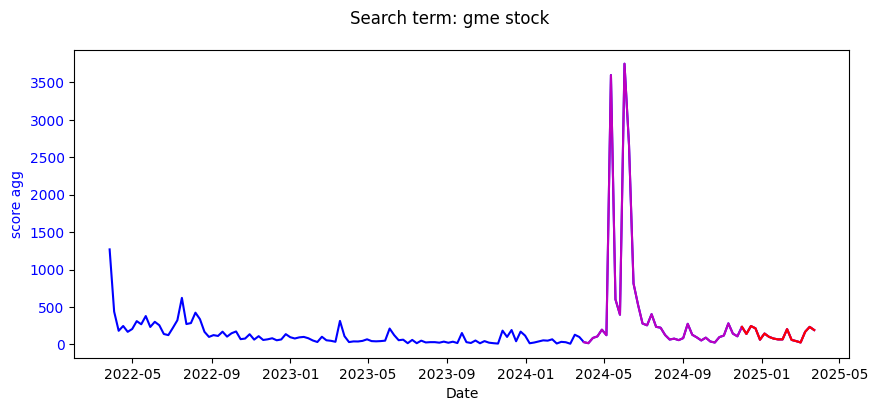

In [25]:
import matplotlib.pyplot as plt

SCORE_COL = "score_agg"
TIME_COLUMN = "week"

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel('Date')
ax.set_ylabel("score agg", color ='b')
ax.tick_params(axis='y', labelcolor = 'b')

for e, key in enumerate(trend_hist_dict.keys()):
    colors = ['b','m','r']
    ax.plot(
        trend_hist_dict[key][TIME_COLUMN], 
        trend_hist_dict[key][SCORE_COL], 
        color = colors[e], label = key
    )

plt.suptitle(f"Search term: {TREND_TERM}")
plt.show()

### helper functions

In [ ]:
from google.cloud.bigquery import QueryJob
from google.cloud.bigquery.table import RowIterator


def _query_bq(query_string: str) -> QueryJob:
    """

    :param query_string: str
        Full SQL query string to execute against BigQuery

    :return: google.cloud.bigquery.job.QueryJob
    """
    return bq_client.query(query_string)

def pull_term_data_from_bq(
          term: tuple = ('mascara', 'makeup')
          , project_id='bigquery-public-data'
          , dataset='google_trends'
          , table_id='top_rising_terms'
    ) -> RowIterator:
    """
    Pull terms based on `in` sql clause from term
    takes a tuple of terms (str) and produces pandas dataset

    :param term: tuple(str)
        A tuple of terms to query for
    :param project_id: str
        project_id that holds the dataset.
    :param dataset: str
        dataset name that holds the table.
    :param table_id: str
        table name

    :return: google.cloud.bigguqery.table.RowIterator
    """
    query = f"""
    SELECT
    week,
    term,
    rank
    FROM `{project_id}.{dataset}.{table_id}`
    WHERE
    lower(term) in {term}
    order by term, 1
    """
    return _query_bq(query_string=query).result()

def pull_term_data_from_bq(
          term: tuple = ('mascara', 'makeup')
          , project_id='bigquery-public-data'
          , dataset='google_trends'
          , table_id='top_rising_terms'
    ) -> RowIterator:
    """
    Pull terms based on `in` sql clause from term
    takes a tuple of terms (str) and produces pandas dataset

    :param term: tuple(str)
        A tuple of terms to query for
    :param project_id: str
        project_id that holds the dataset.
    :param dataset: str
        dataset name that holds the table.
    :param table_id: str
        table name

    :return: google.cloud.bigguqery.table.RowIterator
    """
    query = f"""
    SELECT
    week,
    term,
    rank
    FROM `{project_id}.{dataset}.{table_id}`
    WHERE
    lower(term) in {term}
    order by term, 1
    """

    return _query_bq(query_string=query).result()


def pull_term_data_from_bq_df(
          term: tuple = ('mascara', 'makeup')
          , project_id='bigquery-public-data'
          , dataset='google_trends'
          , table_id='top_rising_terms'
    ) -> pd.DataFrame:
    """
    Pull terms based on `in` sql clause from term
    takes a tuple of terms (str) and produces pandas dataset

    :param term: tuple(str)
        A tuple of terms to query for
    :param project_id: str
        project_id that holds the dataset.
    :param dataset: str
        dataset name that holds the table.
    :param table_id: str
        table name

    :return: pandas.DataFrame
    """
    result = pull_term_data_from_bq(term, project_id, dataset, table_id)

    return result.to_dataframe()

# extract trends from BQ, convert to pandas dataframe
def pull_regexp_term_data_from_bq(
          term: str
          , project_id='bigquery-public-data'
          , dataset='google_trends'
          , table_id='top_rising_terms'
    ) -> RowIterator:
    """
    Pull terms based on `in` sql clause from term
    takes a tuple of terms (str) and produces pandas dataset

    :param term: tuple(str)
        A tuple of terms to query for
    :param project_id: str
        project_id that holds the dataset.
    :param dataset: str
        dataset name that holds the table.
    :param table_id: str
        table name

    :return: google.cloud.bigguqery.table.RowIterator
    """
    query = f"""
    SELECT
    week,
    term,
    rank
    FROM `{project_id}.{dataset}.{table_id}`
    WHERE (
                REGEXP_CONTAINS(LOWER(term), r'{term}')
            )
    order by term
    """
    return _query_bq(query_string=query).result()

# YouTube Data API

references
* API reference: [parameters](https://developers.google.com/youtube/v3/docs/videos/list#parameters)
* video resource [JSON structure](https://developers.google.com/youtube/v3/docs/videos#resource-representation)

### config

In [12]:
from vertexai.generative_models import GenerativeModel, Part

# Set Gemini Flash and Pro models to be used in this notebook
GEMINI_FLASH_MODEL_ID = "gemini-1.5-flash-002"
GEMINI_PRO_MODEL_ID = "gemini-1.5-pro-002"

gemini_flash_model = GenerativeModel(GEMINI_FLASH_MODEL_ID)
gemini_pro_model = GenerativeModel(GEMINI_PRO_MODEL_ID)

# Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

In [11]:
import pandas as pd
from IPython.display import HTML

# import google_auth_oauthlib.flow
from google.cloud import secretmanager
import googleapiclient.discovery
import googleapiclient.errors

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
sm_client = secretmanager.SecretManagerServiceClient()

API_SERVICE_NAME = "youtube"
API_VERSION = "v3"

_SECRET_ID = 'projects/934903580331/secrets/yt-data-api'
_SECRET_VERSION = '{}/versions/1'.format(_SECRET_ID)
_SECRET_NAME = sm_client.secret_path(PROJECT_ID, _SECRET_ID)
print(f"_SECRET_NAME: {_SECRET_NAME}\n")

response = sm_client.access_secret_version(request={"name": _SECRET_VERSION})
# print(f"response: {response}")

YOUTUBE_DATA_API_KEY = response.payload.data.decode("UTF-8")
# print(f"YOUTUBE_DATA_API_KEY: {YOUTUBE_DATA_API_KEY}")

_SECRET_NAME: projects/hybrid-vertex/secrets/projects/934903580331/secrets/yt-data-api



### yt discovery client

> see [src](https://github.com/googleapis/google-api-python-client/blob/main/googleapiclient/discovery.py)

In [13]:
youtube = googleapiclient.discovery.build(
    serviceName=API_SERVICE_NAME, 
    version=API_VERSION, 
    developerKey=YOUTUBE_DATA_API_KEY
)

youtube

## Search YouTube

**duration** (minutes): ['any', 'long', 'medium', 'short']
* short: (-inf, 4)
* medium: [4, 20]
* long: (20, inf)

In [ ]:
TARGET_QUERY = "time travel"

# CHANNEL_ID = "UCvW9uSNy6Lytcnib1CdXrow" # TPB
CHANNEL_ID = "UC9MAhZQQd9egwWCxrwSIsJQ" # AA

NUM_RESULTS = 5
VIDEO_DURATION = "medium"

# order resources in API response
ORDER_CRITERIA = "relevance"  # ['date', 'rating', 'relevance', 'title', 'viewCount']

MAX_DAYS_AGO = 60
PUBLISHED_AFTER_TIMESTAMP = (
    (pd.Timestamp.now() - pd.DateOffset(days=MAX_DAYS_AGO))
    .tz_localize("UTC")
    .isoformat()
)

print(f"search_query: {TARGET_QUERY}")
print(f"channelId: {CHANNEL_ID}")
print(f"video_duration_type: {VIDEO_DURATION}")
print(f"published_after: {PUBLISHED_AFTER_TIMESTAMP}")
print(f"order_criteria: {ORDER_CRITERIA}")
print(f"num_results: {NUM_RESULTS}")

search_query: time travel
channelId: UC9MAhZQQd9egwWCxrwSIsJQ
video_duration_type: medium
published_after: 2025-01-26T20:00:36.471857+00:00
order_criteria: relevance
num_results: 5


### youtube search parameters

* `mostPopular` - Return the most popular videos for the specified content region and video category

* see options for `part` parameter:
  * [contentDetails](https://developers.google.com/youtube/v3/docs/videos#contentDetails)
  * [statisitcs](https://developers.google.com/youtube/v3/docs/videos#statistics)
  * [topicDetails](https://developers.google.com/youtube/v3/docs/videos#topicDetails)

In [15]:
# Using Search:list - https://developers.google.com/youtube/v3/docs/search/list
yt_data_api_request = youtube.search().list(
    part="id,snippet",
    type="video",
    q=TARGET_QUERY,
    videoDuration=VIDEO_DURATION,
    maxResults=NUM_RESULTS,
    publishedAfter=PUBLISHED_AFTER_TIMESTAMP,
    channelId=CHANNEL_ID,
    order=ORDER_CRITERIA,
    videoCaption="closedCaption" # only include videos with CC?
)
yt_data_api_response = yt_data_api_request.execute()

# prepare results dataframe
data_dict = {}
i=1

for video in yt_data_api_response['items']:
    row_name = f"row{i}"
    data_dict.update(
        {
            row_name: {
                'publishedAt': video['snippet']['publishedAt'],
                'videoId': video['id']['videoId'], 
                'videoTitle': video['snippet']['title'],
                'videoDescription': video['snippet']['description'],
                'videoThumbnail': video['snippet']['thumbnails']['high']['url'],
                'videoURL': f"https://www.youtube.com/watch?v={video['id']['videoId']}",
                'channelTitle': video['snippet']['channelTitle'],
                'channelId': video['snippet']['channelId'],
            }
        }
    )
    i+=1

yt_df = pd.DataFrame.from_dict(data_dict, orient='index')
yt_df = yt_df.reset_index(drop=True)

HTML(yt_df.to_html(render_links=True, escape=False))

,publishedAt,videoId,videoTitle,videoDescription,videoThumbnail,videoURL,channelTitle,channelId
0,2025-03-25T15:01:18Z,vaMi79TmqJs,MASSIVE Investigations Launched into Hindenburg Disaster | History's Most Shocking (S1),"The Hindenburg, the pride of Germany, explodes in flames while flying over New Jersey in 1937, sparking a mystery. See more in ...",https://i.ytimg.com/vi/vaMi79TmqJs/hqdefault.jpg,https://www.youtube.com/watch?v=vaMi79TmqJs,HISTORY,UC9MAhZQQd9egwWCxrwSIsJQ
1,2025-03-23T18:00:10Z,HWz-7gQiLBQ,Investigating Cosmic Mysteries | Ancient Aliens,Follow David Childress as he investigates mysteries around the world. See more in this Ancient Aliens compilation. Watch all new ...,https://i.ytimg.com/vi/HWz-7gQiLBQ/hqdefault.jpg,https://www.youtube.com/watch?v=HWz-7gQiLBQ,HISTORY,UC9MAhZQQd9egwWCxrwSIsJQ
2,2025-03-17T18:00:06Z,6Em9JoAuOyY,3 Groundbreaking Gold Finds | The Curse of Oak Island,The crew investigates major finds that could be made of gold. See more in this The Curse of Oak Island compilation. 0:00 Testing ...,https://i.ytimg.com/vi/6Em9JoAuOyY/hqdefault.jpg,https://www.youtube.com/watch?v=6Em9JoAuOyY,HISTORY,UC9MAhZQQd9egwWCxrwSIsJQ


In [ ]:
# yt_data_api_response['items'][0]
# 
# # pprint(yt_data_api_response)

{'etag': 'jisC5xfUqF3p86EwzB_7k-JZMO4',
 'items': [{'etag': 'DDj68gUpa-kr1vdX1STM5SxgPnU',
            'id': {'kind': 'youtube#video', 'videoId': 'NxpZ_g3sMCw'},
            'kind': 'youtube#searchResult',
            'snippet': {'channelId': 'UC9MAhZQQd9egwWCxrwSIsJQ',
                        'channelTitle': 'HISTORY',
                        'description': 'Check out these groundbreaking time '
                                       'travel theories. See more in this '
                                       'Ancient Aliens compilation. 1) 0:00 2) '
                                       '17:36 Watch all new ...',
                        'liveBroadcastContent': 'none',
                        'publishTime': '2025-03-11T18:00:16Z',
                        'publishedAt': '2025-03-11T18:00:16Z',
                        'thumbnails': {'default': {'height': 90,
                                                   'url': 'https://i.ytimg.com/vi/NxpZ_g3sMCw/default.jpg',
                      

### Get summary from Gemini for each video

In [ ]:
def get_gemini_summary_from_youtube_video_url(video_url):
    video_summary_prompt = "Summarize this video."
    
    # Gemini Pro: highest quality
    video_summary_response = gemini_pro_model.generate_content(
        [
            video_summary_prompt,
            Part.from_uri(mime_type="video/webm", uri=video_url)
        ]
    )
    
    # Gemini Flash: prioritize latency/cost
    # video_summary_response = gemini_flash_model.generate_content(
    #     [
    #         video_summary_prompt,
    #         Part.from_uri(mime_type="video/webm", uri=video_url)
    #     ]
    # )

    summary_text = video_summary_response.text    
    return summary_text

# generate summaries 
yt_df["geminiVideoSummary"] = yt_df["videoURL"].apply(
    get_gemini_summary_from_youtube_video_url
)
HTML(yt_df.to_html(render_links=True, escape=False, max_rows=3))

,publishedAt,videoId,videoTitle,videoDescription,videoThumbnail,videoURL,channelTitle,channelId,geminiVideoSummary
0,2025-03-25T15:01:18Z,vaMi79TmqJs,MASSIVE Investigations Launched into Hindenburg Disaster | History's Most Shocking (S1),"The Hindenburg, the pride of Germany, explodes in flames while flying over New Jersey in 1937, sparking a mystery. See more in ...",https://i.ytimg.com/vi/vaMi79TmqJs/hqdefault.jpg,https://www.youtube.com/watch?v=vaMi79TmqJs,HISTORY,UC9MAhZQQd9egwWCxrwSIsJQ,"Here is a summary of the provided video from History’s Most Shocking:\n\nThe Hindenburg was a German zeppelin that was the ultimate experience in luxury air travel during the last century. In 1937, it was on its way to the United States when it tragically exploded. The disaster happened over a naval air station in Lakehurst, New Jersey on May 6, 1937. It was carrying 36 passengers and 61 crew members. The rear of the Hindenburg exploded just four minutes after landing procedures were initiated, killing 36 people, including one ground worker. Miraculously, 62 passengers and crew members survived.\n\nThe cause of the accident was initially unknown, leading to speculation of sabotage by a passenger, Joseph Spah. German and American investigations launched after the event determined that hydrogen ignited within the balloon’s tail section.\n\nThe Hindenburg disaster became a viral moment, as images of the explosion were seen on newsreels and in movie theaters around the world. \n\nHowever, the exact cause of the spark remained unknown. In the video, Dr. Michio Kaku explains that the skin of the zeppelin was probably supercharged with electricity, but it had nowhere to go. A similar situation is like walking across carpet with socks, creating static electricity. The combination of aluminum powder and iron oxide on the fabric created a flammable mixture that was likely ignited by an electric spark caused by a buildup of static electricity and rainy, stormy conditions."
1,2025-03-23T18:00:10Z,HWz-7gQiLBQ,Investigating Cosmic Mysteries | Ancient Aliens,Follow David Childress as he investigates mysteries around the world. See more in this Ancient Aliens compilation. Watch all new ...,https://i.ytimg.com/vi/HWz-7gQiLBQ/hqdefault.jpg,https://www.youtube.com/watch?v=HWz-7gQiLBQ,HISTORY,UC9MAhZQQd9egwWCxrwSIsJQ,"Ancient astronaut theorists explore the mysterious stone structures of Carnac on the northwest coast of France. The megaliths are more than 3,000 granite rocks arranged in various shapes. Local legend tells of invading Roman soldiers turned into stone by Merlin the Magician. But the rocks also have magnetic properties, are cut on one side, and nearly all of them come to a point. Did their placement create some kind of geomagnetic field? These rock formations may be one of the places on earth that have been recognized as points with high magnetic forces. Other places such as the Giza pyramids, Machu Picchu, and Baalbek in Lebanon all have similar properties. These locations may have been chosen to harness an ancient world energy grid. The Carnac stones, according to the legend, were built to be viewed from above. Three similar locations that can be viewed from space are the Great Wall of China, the Nazca lines, and Carnac. Could these stone structures have been erected for or by extraterrestrials?"
2,2025-03-17T18:00:06Z,6Em9JoAuOyY,3 Groundbreaking Gold Finds | The Curse of Oak Island,The crew investigates major finds that could be made of gold. See more in this The Curse of Oak Island compilation. 0:00 Testing ...,https://i.ytimg.com/vi/6Em9JoAuOyY/hqdefault.jpg,https://www.youtube.com/watch?v=6Em9JoAuOyY,HISTORY,UC9MAhZQQd9egwWCxrwSIsJQ,"Marty Lagina, Alex Lagina and Craig Tester visit Saint Mary’s University in Halifax. They want to find out if an antique brooch found on lot 21 is partially made of gold. Dr. Christa Brosseau, an associate professor of chemistry, and her colleague, Dr. Xiangyang, examine the brooch with a high-powered scannin

### Load response dataframe to BigQuery

In [19]:
BQ_DATASET = 'youtube_video_analysis' # os.getenv("BQ_DATASET")
TRENDING_YT_RESPONSE_TABLE = "yt_search_responses_v2"

In [ ]:
YOUTUBE_API_LOAD_JOB = bq_client.load_table_from_dataframe(
    yt_df,
    f"{BQ_DATASET}.{TRENDING_YT_RESPONSE_TABLE}",
    # job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE"),
)

# Wait for the load job to complete
YOUTUBE_API_LOAD_JOB.result()

LoadJob<project=hybrid-vertex, location=us-central1, id=173da702-a0dc-4d82-a89e-585ef8d41fff>

## YouTube Trends

In [26]:
request = youtube.videos().list(
    part="snippet,contentDetails,statistics",
    chart="mostPopular",
    regionCode="US",
    maxResults=7,
)
response = request.execute()
# print(response)

In [27]:
# prepare results dataframe
trend_dict = {}
i=1

for video in response['items']:
    row_name = f"row{i}"

    # the `tags` field is ommitted if video doesnt have tags
    if "tags" in video['snippet'].keys():
        TAGS_VALUE = video['snippet']['tags']
    else:
        TAGS_VALUE = []

    trend_dict.update(
        {
            row_name: {
                'publishedAt': video['snippet']['publishedAt'],
                'videoId': video['id'],
                'videoTitle': video['snippet']['title'],
                'videoDescription': video['snippet']['description'],
                'duration': video['contentDetails']['duration'],
                # 'videoTags': video['snippet']['tags'],
                'videoTags': TAGS_VALUE,
                'viewCount': video['statistics']['viewCount'],
                'likeCount': video['statistics']['likeCount'],
                'favoriteCount': video['statistics']['favoriteCount'],
                'commentCount': video['statistics']['commentCount'],
                'videoURL': f"https://www.youtube.com/watch?v={video['id']}",
                'videoThumbnail': video['snippet']['thumbnails']['high']['url'],
                'channelTitle': video['snippet']['channelTitle'],
                'channelId': video['snippet']['channelId'],
            }
        }
    )

    i+=1

yt_trend_df = pd.DataFrame.from_dict(trend_dict, orient='index')
yt_trend_df = yt_trend_df.reset_index(drop=True)

HTML(yt_trend_df.to_html(render_links=True, escape=False, max_rows=3))

,publishedAt,videoId,videoTitle,videoDescription,duration,videoTags,viewCount,likeCount,favoriteCount,commentCount,videoURL,videoThumbnail,channelTitle,channelId
0,2025-03-26T18:50:00Z,vH0OetsEZ7A,The LeBron James Unfiltered Full Interview With The Pat McAfee Show,"Welcome to The Pat McAfee Show LIVE from Noon-3PM EST Mon-Fri. You can also find us live on ESPN, ESPN+, & TikTok!\n\nBecome a #McAfeeMafia member! https://www.youtube.com/channel/UCxcTeAKWJca6XyJ37_ZoKIQ/join\n\nSUBSCRIBE:\nhttps://www.youtube.com/channel/UCxcTeAKWJca6XyJ37_ZoKIQ?sub_confirmation=1\n\nMERCH: https://store.patmcafeeshow.com\n\nSubscribe to the Pat McAfee Show(s)!\n @Hammer Dahn \n @The CONCAFA Show \n @The Pod \n @The Pat McAfee Show \n \nMERCH: https://store.patmcafeeshow.com\nSPONSOR THE SHOW: https://www.patmcafeeshow.com/partnerships\n\n#PatMcAfee #NFL",PT1H12M42S,"[pat mcafee, podcast, sports, nfl, ncaa, football, for the brand, punter, kicker, pat mcafee show, american football, nfl news, pat mcafee clips, pat mcafee reacts, pat mcafee highlights, pat mcafee live, pat mcafee show live, pat mcafee podcast, the pat mcafee show, McAfeeESPN2023, lebron james, lebron james song, lebron james highlights, lebron james and bronny, lebron james stephen a smith, lebron james pat mcafee, pat mcafee lebron, lebron interview, lebron podcast]",1135166,45050,0,5340,https://www.youtube.com/watch?v=vH0OetsEZ7A,https://i.ytimg.com/vi/vH0OetsEZ7A/hqdefault.jpg,The Pat McAfee Show,UCxcTeAKWJca6XyJ37_ZoKIQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2025-03-25T15:00:41Z,UWMzKXsY9A4,Final Destination Bloodlines | Official Trailer,"Death is a relentless son of a *****. #FinalDestination #Bloodlines - Only in Theaters and IMAX May 16. #FilmedforIMAX\n\nThe newest chapter in New Line Cinema’s bloody successful franchise takes audiences back to the very beginning of Death’s twisted sense of justice—“Final Destination Bloodlines.” \n\nPlagued by a violent recurring nightmare, college student Stefanie heads home to track down the one person who might be able to break the cycle and save her family from the grisly demise that inevitably awaits them all. \n“Final Destination Bloodlines” stars Kaitlyn Santa Juana, Teo Briones, Richard Harmon, Owen Patrick Joyner, Anna Lore, with Brec Bassinger, and Tony Todd.\n\nThe film is directed by Adam Stein & Zach Lipovsky. The screenplay is by Guy Busick & Lori Evans Taylor, and story is by Jon Watts and Guy Busick & Lori Evans Taylor. It is based on characters created by Jeffrey Reddick.\n“Final Destination Bloodlines” is produced by Craig Perry, Sheila Hanahan Taylor, Jon Watts, Dianne McGunigle and Toby Emmerich. The executive producers are David Siegel and Warren Zide. The behind-the-camera talent includes director of photography Christian Sebaldt and production designer Rachel O’Toole. The film is edited by Sabrina Pitre. The music is by Tim Wynn. The costumes are designed by Michelle Hunter. The casting is by Rich Delia.\n\nNew Line Cinema presents A Practical Pictures / Freshman Year / Fireside Films Production: “Final Destination Bloodlines.” The film will be distributed in theaters and IMAX worldwide by Warner Bros. Pictures, in theaters only nationwide on May 16, 2025, and internationally beginning on 14 May 2025.",PT2M25S,"[Adam B Stein, Anna Lore, Brec Bassinger, ComingSoon, Disaster Movie, FinalDestination, FinalDestinationBloodLines, Guy Busick, Horror, Jon Watts, Kaitlyn Santa Juana, Lori Evans Taylor, May2025, Owen Patrick Joyner, Richard Harmon, Rya Kihlstedt, Teo Briones, Tony Todd, Trailer, Trailer2025, WB, WBD, WarnerBros, WarnerBrothers, Zach Lipovsky]",11938794,170184,0,14474,https://www.youtube.com/watch?v=UWMzKXsY9A4,https://i.ytimg.com/vi/UWMzKXsY9A4/hqdefault.jpg,Warner Bros.,UCjmJDM5pRKbUlVIzDYYWb6g


### Load response dataframe to BigQuery

In [ ]:
# BQ_DATASET = 'youtube_video_analysis' # os.getenv("BQ_DATASET")
YT_TRENDS_RESPONSE_TABLE = "yt_trending_videos_v2"

YOUTUBE_API_LOAD_JOB_v2 = bq_client.load_table_from_dataframe(
    yt_trend_df,
    f"{BQ_DATASET}.{YT_TRENDS_RESPONSE_TABLE}",
    # job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE"),
)

# Wait for the load job to complete
YOUTUBE_API_LOAD_JOB_v2.result()

LoadJob<project=hybrid-vertex, location=us-central1, id=7cc2943b-27c3-4e77-b3e6-0967d9624fe7>

```python
{
  "kind": "youtube#videoListResponse",
  "etag": etag,
  "nextPageToken": string,
  "prevPageToken": string,
  "pageInfo": {
    "totalResults": integer,
    "resultsPerPage": integer
  },
  "items": [
    video Resource
  ]
}
```